In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import clear_output
from torch.utils.data import Dataset
from PIL import Image



In [2]:
class ResidualBlock(nn.Module):
    def __init__(self,in_channel):
        super().__init__()
        self.block=nn.Sequential(
            nn.ReflectionPad2d(
               1,
            ),
            nn.Conv2d(in_channels=in_channel,out_channels=in_channel,kernel_size=3),
            nn.InstanceNorm2d(in_channel),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels=in_channel,out_channels=in_channel,kernel_size=3),
            nn.InstanceNorm2d(in_channel),
            
        )

    
    def forward(self,X):
        return X + self.block(X)



In [3]:
class GeneratorResNet(nn.Module):
    def __init__(self,input_shape,num_residual_blocks):
        super().__init__()
        channels=input_shape[0]
        out_channels=64
        model=[
            nn.ReflectionPad2d(channels),
            nn.Conv2d(in_channels=channels,out_channels=out_channels,kernel_size=7,stride=1),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
            
        ]
        in_channels=out_channels
       
        for _ in range(2):
            out_channels*=2
            model +=[
                nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=3,stride=2,padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
            ]
            in_channels=out_channels
            
       
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_channels)]

        
        for _ in range(2):
            out_channels //= 2
            model +=[
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=3,stride=1,padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True)
                    
            ]
            in_channels=out_channels
            
       
        model +=[
            nn.ReflectionPad2d(channels),
            nn.Conv2d(in_channels=out_channels,out_channels=channels,kernel_size=7),
            nn.Tanh()
            
        ]
        self.model=nn.Sequential(*model)

    
    def forward(self,X):
        return self.model(X)
        
        

        

In [4]:
class Discriminator(nn.Module):
    def __init__(self,input_shape):
        super().__init__()
        channels,height,width=input_shape
        
        
        self.output_shape=(1,height//2**4,width//2**4)
        def discriminator_block(in_channels,out_channels,normalize=True):
            layers=[
                nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=4,stride=2,padding=1)
            ]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2,inplace=True))
            return layers
            
        # C64 -> C128 -> C256 -> C512
        self.model=nn.Sequential(
            *discriminator_block(in_channels=channels,out_channels=64,normalize=False),
            *discriminator_block(64, out_channels=128),
            *discriminator_block(128, out_channels=256),
            *discriminator_block(256, out_channels=512),
            nn.ZeroPad2d((1,0,1,0)),
            nn.Conv2d(in_channels=512,out_channels=1,kernel_size=4,padding=1)
            
        )

    
    def forward(self,X):
        return self.model(X)
        
                
        

In [5]:
import os
import numpy as np
import torchvision.transforms as transforms
from torch.autograd import Variable
import glob
import random



In [6]:
def convert_to_rgb(image):
    rgb_image=Image.new("RGB",image.size)
    rgb_image.paste(image)
    return rgb_image

In [7]:
class ImageDataSet(Dataset):
    def __init__(self,root,transforms_=None,unaligned=True,mode='train'):
        self.transform=transforms.Compose(transforms_)
        self.unaligned=unaligned
        self.files_A=sorted(glob.glob(os.path.normpath(os.path.join(root, "%sA" % mode) + "/*.*")))
        self.files_B=sorted(glob.glob(os.path.normpath(os.path.join(root, "%sB" % mode) + "/*.*")))

    
    def __getitem__(self,index):
        image_A = Image.open(self.files_A[index % len(self.files_A)])
        
        if self.unaligned:
            image_B = Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)])
        else:
            image_B = Image.open(self.files_B[index % len(self.files_B)])
            
        if image_A.mode !='RGB':
            image_A = convert_to_rgb(image_A)
        if image_B.mode != "RGB":
            image_B = convert_to_rgb(image_B)
        item_A = self.transform(image_A)
        item_B = self.transform(image_B)
        
        return {"A": item_A, "B": item_B}
        
    def __len__(self):
        return max(len(self.files_A), len(self.files_B))
        
        

In [8]:
class ReplayBuffer:
    def __init__(self,max_size=50):
        assert max_size > 0, "Empty buffer."
        self.max_size = max_size
        self.data = []
        
    def push_and_pop(self,data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[
                        i
                    ] = element  
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))

In [9]:
class LambdaLR():
    def __init__(self,n_epochs,offset,decay_start_epoch):
        assert (
            n_epochs - decay_start_epoch
        ) > 0,"Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch
        
    def step(self,epoch):
         return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch) / (
            self.n_epochs - self.decay_start_epoch
        )

In [10]:
def initialize_conv_weights_normal(m):
     classname = m.__class__.__name__
     if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
     elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [11]:
import itertools
import time
import datetime
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision.utils import make_grid


In [12]:
device="cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device:{device}")

Using device:cuda


In [13]:
Tensor = torch.cuda.FloatTensor if device == "cuda" else torch.Tensor
Tensor

torch.cuda.FloatTensor

In [14]:
class Hyperparameters(object):
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [15]:
hp = Hyperparameters(
    epoch=0,
    n_epochs=200,
    dataset_train_mode="train",
    dataset_test_mode="test",
    batch_size=8,
    lr=2e-4,
    decay_start_epoch=100,
    b1=0.5,
    b2=0.999,
    n_cpu=5,
    img_size=128,
    channels=3,
    n_critic=5,
    sample_interval=100,
    num_residual_blocks=15,
    lambda_cyc=10.0,
    lambda_id=5.0,
)

In [16]:
root_path='/kaggle/input/gender-change/genderchange'

In [17]:
def show_image(img,size=10):
    img=img/2 +0.5
    npimg=img.numpy()
    plt.figure(figsize=(size, size))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [18]:
def to_img(x):
    
    x=x.view(x.size[0]*2,hp.channels, hp.img_size, hp.img_size)
    return x

In [19]:
import matplotlib.image as mpimg
def plot_output(path,x,y):
    img = mpimg.imread(path)
    plt.figure(figsize=(x, y))
    plt.imshow(img)
    plt.show()

In [20]:
transforms_ = [
    transforms.Resize((hp.img_size, hp.img_size), Image.BICUBIC),  
    transforms.RandomHorizontalFlip(p=0.5),        
    transforms.RandomRotation(degrees=15),         
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  
    transforms.RandomResizedCrop(size=(128, 128), scale=(0.8, 1.0)), 
    transforms.ToTensor(),                         
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  
]

In [21]:
dataset=ImageDataSet(root_path, mode=hp.dataset_train_mode, transforms_=transforms_)
val_dataset=ImageDataSet(root_path,mode=hp.dataset_test_mode,transforms_=transforms_)

In [22]:
print(f"Number of samples in the train dataset: {len(dataset)}")
print(f"Number of samples in the test dataset: {len(val_dataset)}")



Number of samples in the train dataset: 4272
Number of samples in the test dataset: 20


In [23]:
train_dataloader = DataLoader(
    dataset=dataset,
    batch_size=hp.batch_size,
    shuffle=True,
)

val_dataloader=DataLoader(
    dataset=val_dataset,
    batch_size=hp.batch_size,
    shuffle=False
    
)


In [24]:
def save_img_samples(batches_done):
    
    print("batches_done ", batches_done)
    imgs = next(iter(val_dataloader))

    Gen_AB.eval()
    Gen_BA.eval()

    real_A = Variable(imgs["A"].type(Tensor))
    fake_B = Gen_AB(real_A)
    real_B = Variable(imgs["B"].type(Tensor))
    fake_A = Gen_BA(real_B)
    
    real_A = make_grid(real_A, nrow=16, normalize=True)
    real_B = make_grid(real_B, nrow=16, normalize=True)
    fake_A = make_grid(fake_A, nrow=16, normalize=True)
    fake_B = make_grid(fake_B, nrow=16, normalize=True)
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
    path = root_path + "/%s.png" % (batches_done) 
    save_image(image_grid, path, normalize=False)
    return path

In [25]:
criterion_GAN=nn.MSELoss()
criterion_cycle=nn.L1Loss()
criterion_identity=nn.L1Loss()
input_shape = (hp.channels, hp.img_size, hp.img_size)

In [26]:
Gen_AB=GeneratorResNet(input_shape=input_shape,num_residual_blocks=hp.num_residual_blocks).to(device)
Gen_BA=GeneratorResNet(input_shape=input_shape,num_residual_blocks=hp.num_residual_blocks).to(device)

Disc_A=Discriminator(input_shape=input_shape).to(device)
Disc_B=Discriminator(input_shape=input_shape).to(device)

In [27]:
Gen_AB.apply(initialize_conv_weights_normal)
Gen_BA.apply(initialize_conv_weights_normal)

Disc_A.apply(initialize_conv_weights_normal)
Disc_B.apply(initialize_conv_weights_normal)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): ZeroPad2d((1, 0, 1, 0))
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [28]:
Gen_AB.load_state_dict(torch.load('/kaggle/input/pre-trainedweights/Gen-AB-PreWeights-3.pth')['Gen_AB'])
Gen_BA.load_state_dict(torch.load('/kaggle/input/pre-trainedweights/Gen-BA-PreWeights-3.pth')['Gen_BA'])
Disc_A.load_state_dict(torch.load('/kaggle/input/pre-trainedweights/Disc-A-PreWeights-3.pth')['Disc_A'])
Disc_B.load_state_dict(torch.load('/kaggle/input/pre-trainedweights/Disc-B-PreWeights-3.pth')['Disc_B'])


<All keys matched successfully>

In [29]:
fake_A_buffer = ReplayBuffer()

fake_B_buffer = ReplayBuffer()

In [30]:
optimizer_G = torch.optim.Adam(
    itertools.chain(Gen_AB.parameters(), Gen_BA.parameters()),
    lr=hp.lr,
    betas=(hp.b1, hp.b2),
)
optimizer_Disc_A = torch.optim.Adam(Disc_A.parameters(), lr=hp.lr, betas=(hp.b1, hp.b2))

optimizer_Disc_B = torch.optim.Adam(Disc_B.parameters(), lr=hp.lr, betas=(hp.b1, hp.b2))

In [31]:
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
    optimizer_G, lr_lambda=LambdaLR(hp.n_epochs, hp.epoch, hp.decay_start_epoch).step
)

lr_scheduler_Disc_A = torch.optim.lr_scheduler.LambdaLR(
    optimizer_Disc_A,
    lr_lambda=LambdaLR(hp.n_epochs, hp.epoch, hp.decay_start_epoch).step,
)

lr_scheduler_Disc_B = torch.optim.lr_scheduler.LambdaLR(
    optimizer_Disc_B,
    lr_lambda=LambdaLR(hp.n_epochs, hp.epoch, hp.decay_start_epoch).step,
)

In [32]:
def train(
    Gen_BA,
    Gen_AB,
    Disc_A,
    Disc_B,
    train_dataloader,
    n_epochs,
    criterion_identity,
    criterion_cycle,
    lambda_cyc,
    criterion_GAN,
    optimizer_G,
    fake_A_buffer,
    fake_B_buffer,
    clear_output,
    optimizer_Disc_A,
    optimizer_Disc_B,
    Tensor,
    sample_interval,
    lambda_id,
):
    
   
    for epoch in range(hp.epoch, n_epochs):
        for i, batch in enumerate(train_dataloader):
       
            real_A = Variable(batch["A"].type(Tensor))
            real_B = Variable(batch["B"].type(Tensor))

            valid = Variable(
                Tensor(np.ones((real_A.size(0), *Disc_A.output_shape))),
                requires_grad=False,
            )

            fake = Variable(
                Tensor(np.zeros((real_A.size(0), *Disc_A.output_shape))),
                requires_grad=False,
            )


            Gen_AB.train()
            Gen_BA.train()

          
            optimizer_G.zero_grad()

           
            loss_id_A = criterion_identity(Gen_BA(real_A), real_A)

           
            loss_id_B = criterion_identity(Gen_AB(real_B), real_B)

            loss_identity = (loss_id_A + loss_id_B) / 2

            
            fake_B = Gen_AB(real_A)

            loss_GAN_AB = criterion_GAN(Disc_B(fake_B), valid)

          
            fake_A = Gen_BA(real_B)

            loss_GAN_BA = criterion_GAN(Disc_A(fake_A), valid)

            loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2

           
            reconstructed_A = Gen_BA(fake_B)

            loss_cycle_A = criterion_cycle(reconstructed_A, real_A)

            
            reconstructed_B = Gen_AB(fake_A)

            loss_cycle_B = criterion_cycle(reconstructed_B, real_B)

            loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

           
            loss_G = loss_GAN + lambda_cyc * loss_cycle + lambda_id * loss_identity

            loss_G.backward()

            
            optimizer_G.step()

           
            optimizer_Disc_A.zero_grad()

            loss_real = criterion_GAN(Disc_A(real_A), valid)           

            fake_A_ = fake_A_buffer.push_and_pop(fake_A)

            loss_fake = criterion_GAN(Disc_A(fake_A_.detach()), fake)

            loss_Disc_A = (loss_real + loss_fake) / 2
            loss_Disc_A.backward()

            optimizer_Disc_A.step()


            optimizer_Disc_B.zero_grad()

            
            loss_real = criterion_GAN(Disc_B(real_B), valid)

            
            fake_B_ = fake_B_buffer.push_and_pop(fake_B)

            loss_fake = criterion_GAN(Disc_B(fake_B_.detach()), fake)

            
            loss_Disc_B = (loss_real + loss_fake) / 2

            
            loss_Disc_B.backward()

           
            optimizer_Disc_B.step()

            loss_D = (loss_Disc_A + loss_Disc_B) / 2

           
            batches_done = epoch * len(train_dataloader) + i

            batches_left = n_epochs * len(train_dataloader) - batches_done


            print(
                "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, adv: %f, cycle: %f, identity: %f]"
                % (
                    epoch,
                    n_epochs,
                    i,
                    len(train_dataloader),
                    loss_D.item(),
                    loss_G.item(),
                    loss_GAN.item(),
                    loss_cycle.item(),
                    loss_identity.item(),

                )
            )

            
            if batches_done % sample_interval == 0:
                clear_output()
                
        
                


In [ ]:
train(
    Gen_BA=Gen_BA,
    Gen_AB=Gen_AB,
    Disc_A=Disc_A,
    Disc_B=Disc_B,
    train_dataloader=train_dataloader,
    n_epochs=hp.n_epochs,
    criterion_identity=criterion_identity,
    criterion_cycle=criterion_cycle,
    lambda_cyc=hp.lambda_cyc,
    criterion_GAN=criterion_GAN,
    optimizer_G=optimizer_G,
    fake_A_buffer=fake_A_buffer,
    fake_B_buffer=fake_B_buffer,
    clear_output=clear_output,
    optimizer_Disc_A=optimizer_Disc_A,
    optimizer_Disc_B=optimizer_Disc_B,
    Tensor=Tensor,
    sample_interval=hp.sample_interval,
    lambda_id=hp.lambda_id,
)

[Epoch 14/200] [Batch 225/534] [D loss: 0.137832] [G loss: 2.439245, adv: 0.498617, cycle: 0.136368, identity: 0.115390]
[Epoch 14/200] [Batch 226/534] [D loss: 0.102882] [G loss: 2.046773, adv: 0.560717, cycle: 0.105602, identity: 0.086007]
[Epoch 14/200] [Batch 227/534] [D loss: 0.148895] [G loss: 2.005362, adv: 0.609848, cycle: 0.099359, identity: 0.080385]
[Epoch 14/200] [Batch 228/534] [D loss: 0.192874] [G loss: 1.663290, adv: 0.372592, cycle: 0.089994, identity: 0.078152]
[Epoch 14/200] [Batch 229/534] [D loss: 0.194874] [G loss: 1.922239, adv: 0.532811, cycle: 0.094849, identity: 0.088188]
[Epoch 14/200] [Batch 230/534] [D loss: 0.083669] [G loss: 2.011002, adv: 0.594166, cycle: 0.101046, identity: 0.081275]
[Epoch 14/200] [Batch 231/534] [D loss: 0.132963] [G loss: 2.065731, adv: 0.632516, cycle: 0.103484, identity: 0.079676]
[Epoch 14/200] [Batch 232/534] [D loss: 0.121190] [G loss: 2.000561, adv: 0.500550, cycle: 0.103567, identity: 0.092867]
[Epoch 14/200] [Batch 233/534] [

In [ ]:
from PIL import Image

test_img=Image.open('/kaggle/input/gender-change/genderchange/testA/man_717.jpg')
test_transform=transforms.Compose( [
    transforms.Resize((hp.img_size, hp.img_size), Image.BICUBIC),  
    transforms.RandomHorizontalFlip(p=0.5),        
    transforms.RandomRotation(degrees=15),         
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  
    transforms.RandomResizedCrop(size=(128, 128), scale=(0.8, 1.0)), 
    transforms.ToTensor(),                         
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  
])
test_img=test_transform(test_img)

with torch.inference_mode():
    test_img=test_img.unsqueeze(dim=0)
    test_img=Variable(test_img.type(Tensor))
    model_pred=Gen_AB(test_img)

plt.imshow(model_pred.squeeze(dim=0).permute(1,2,0).cpu().numpy())
    
    


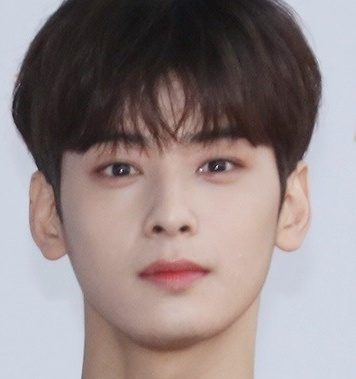

In [35]:
Image.open('/kaggle/input/gender-change/genderchange/testA/man_717.jpg')

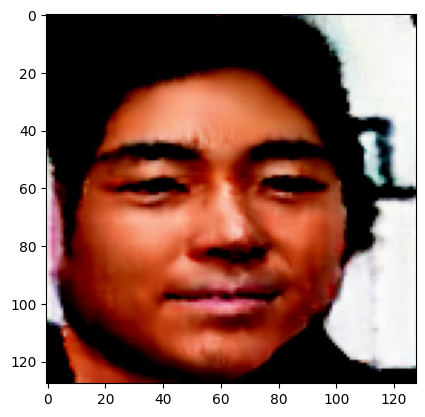

In [37]:
from PIL import Image

test_img=Image.open('/kaggle/input/gender-change/genderchange/testB/woman_3935.jpg')
test_transform=transforms.Compose( [
    transforms.Resize((hp.img_size, hp.img_size), Image.BICUBIC),  
    transforms.RandomHorizontalFlip(p=0.5),        
    transforms.RandomRotation(degrees=15),         
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  
    transforms.RandomResizedCrop(size=(128, 128), scale=(0.8, 1.0)), 
    transforms.ToTensor(),                         
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  
])
test_img=test_transform(test_img)

with torch.inference_mode():
    test_img=test_img.unsqueeze(dim=0)
    test_img=Variable(test_img.type(Tensor))
    model_pred=Gen_BA(test_img)

plt.imshow(model_pred.squeeze(dim=0).permute(1,2,0).cpu().numpy())
    
    


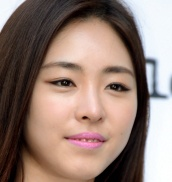

In [38]:
Image.open('/kaggle/input/gender-change/genderchange/testB/woman_3935.jpg')

In [39]:
import random
def plot_transformationWM(path:str):
    test_img=Image.open(path)
    test_transform=transforms.Compose( [
        transforms.Resize((hp.img_size, hp.img_size), Image.BICUBIC),  
        transforms.RandomHorizontalFlip(p=0.5),        
        transforms.RandomRotation(degrees=15),         
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  
        transforms.RandomResizedCrop(size=(128, 128), scale=(0.8, 1.0)), 
        transforms.ToTensor(),                         
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  
    ])
    test_img=test_transform(test_img)
    
    with torch.inference_mode():
        test_img=test_img.unsqueeze(dim=0)
        test_img=Variable(test_img.type(Tensor))
        model_pred=Gen_BA(test_img)
    plt.figure(figsize=(15,20))
    plt.subplot(1,2,1)
    plt.imshow(Image.open(path))
    plt.title("Original Image")
    plt.subplot(1,2,2)
    plt.imshow(model_pred.squeeze(dim=0).permute(1,2,0).cpu().numpy())
    plt.title("Transformed Image")
    random_title="random"+ str(random.randint(0,10000))
    plt.savefig(f'{random_title}.png')
    

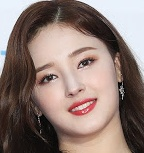

In [38]:
Image.open('/kaggle/input/gender-change/genderchange/testB/woman_551.jpg')

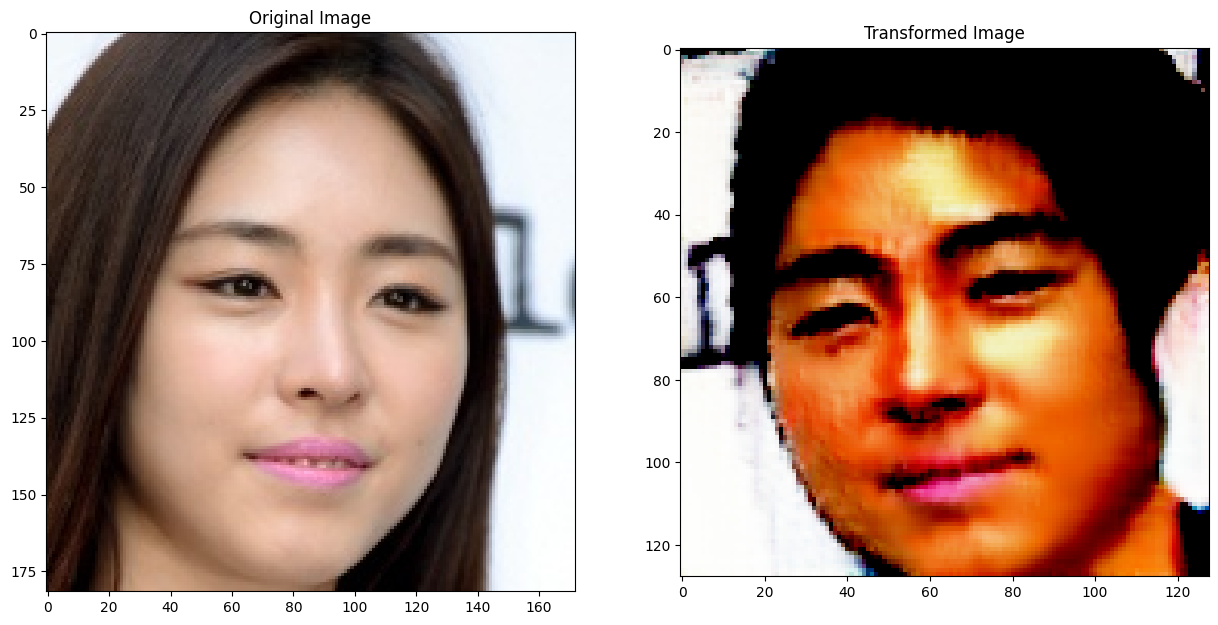

In [39]:
plot_transformationWM('/kaggle/input/gender-change/genderchange/testB/woman_3935.jpg')

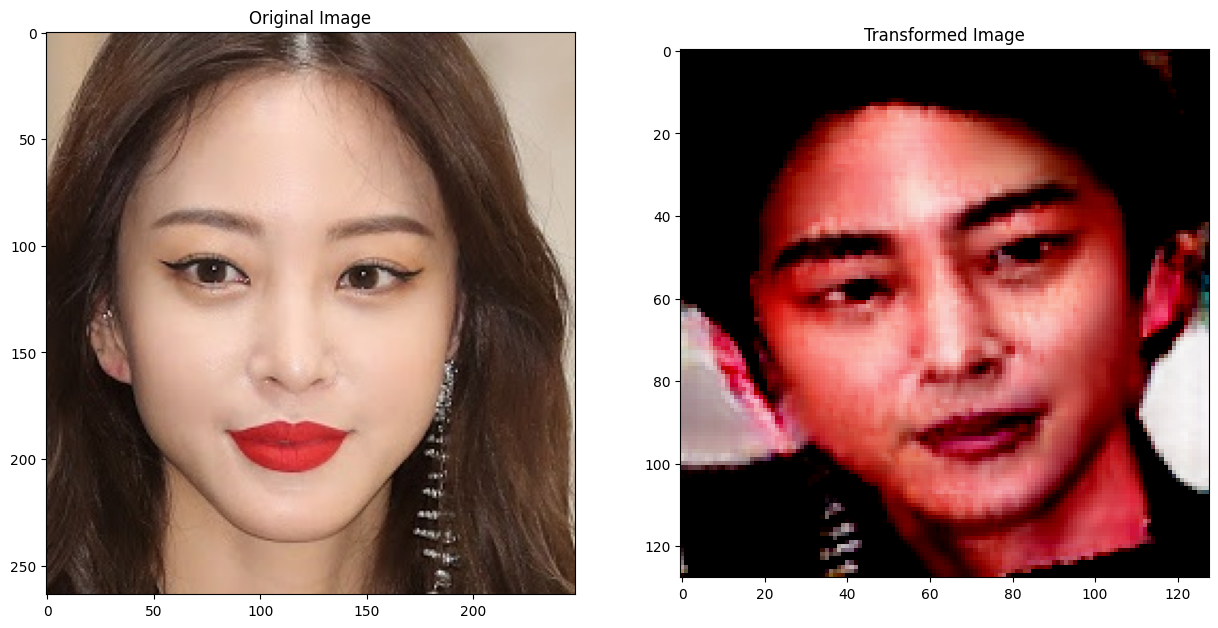

In [40]:
plot_transformationWM('/kaggle/input/gender-change/genderchange/trainB/woman_1047.jpg')

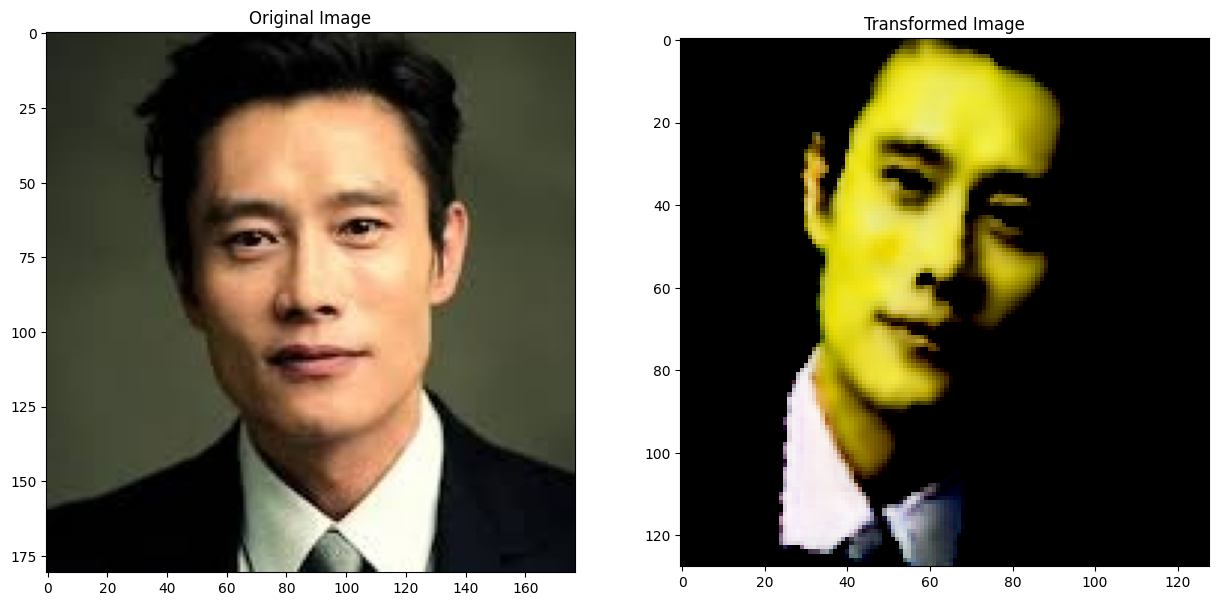

In [41]:
plot_transformationWM('/kaggle/input/gender-change/genderchange/testA/man_3476.jpg')

In [41]:
def plot_transformationMW(path:str):
    test_img=Image.open(path)
    test_transform=transforms.Compose( [
        transforms.Resize((hp.img_size, hp.img_size), Image.BICUBIC),  
        transforms.RandomHorizontalFlip(p=0.5),        
        transforms.RandomRotation(degrees=15),         
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  
        transforms.RandomResizedCrop(size=(128, 128), scale=(0.8, 1.0)), 
        transforms.ToTensor(),                         
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  
    ])
    test_img=test_transform(test_img)
    
    with torch.inference_mode():
        test_img=test_img.unsqueeze(dim=0)
        test_img=Variable(test_img.type(Tensor))
        model_pred=Gen_AB(test_img)
    plt.figure(figsize=(15,20))
    plt.subplot(1,2,1)
    plt.imshow(Image.open(path))
    plt.title("Original Image")
    plt.subplot(1,2,2)
    plt.imshow(model_pred.squeeze(dim=0).permute(1,2,0).cpu().numpy())
    plt.title("Transformed Image")
    

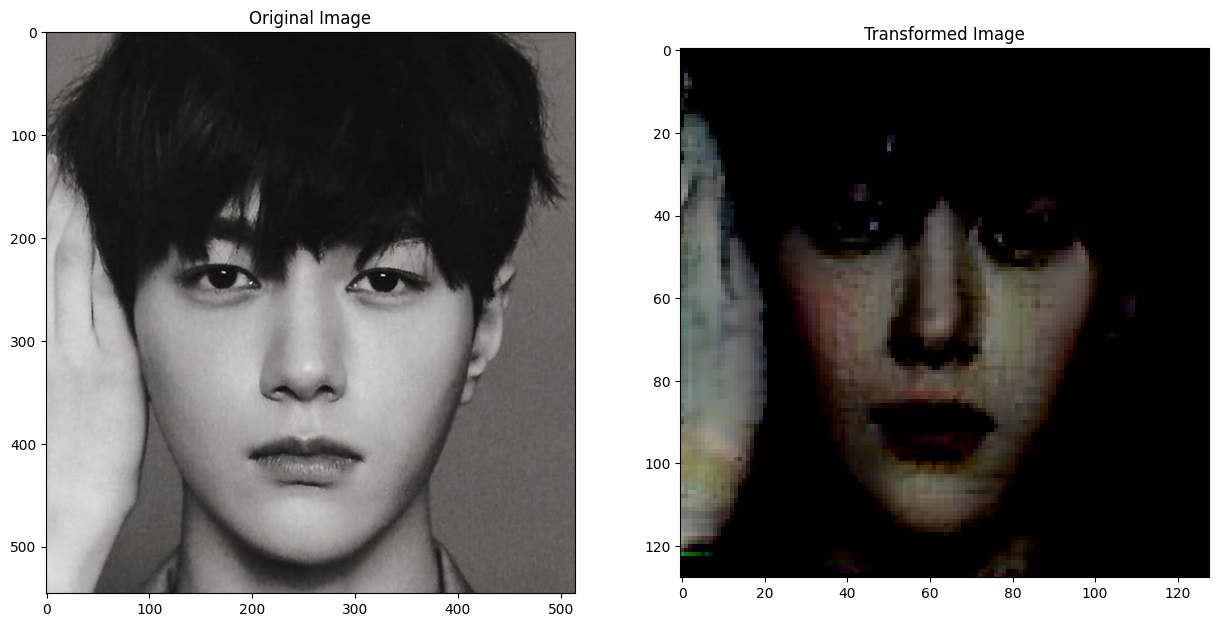

In [42]:
plot_transformationMW('/kaggle/input/gender-change/genderchange/testA/man_772.jpg')

In [ ]:
Gen_AB_dict={'Gen_AB':Gen_AB.state_dict()}
torch.save(Gen_AB_dict,'Gen-AB-PreWeights-4.pth')

In [ ]:
Gen_BA_dict={'Gen_BA':Gen_BA.state_dict()}
torch.save(Gen_BA_dict,'Gen-BA-PreWeights-4.pth')

In [ ]:
Disc_A_dict={'Disc_A':Disc_A.state_dict()}
torch.save(Disc_A_dict,'Disc-A-PreWeights-4.pth')

In [ ]:
Disc_B_dict={'Disc_B':Disc_B.state_dict()}
torch.save(Disc_B_dict,'Disc-B-PreWeights-4.pth')